In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from joblib import Parallel, delayed
import gudhi

# --- Parameters ---
window_size  = 20
stride       = 5
max_dim      = 2
epsilons     = np.linspace(0, 1.0, 30)

# --- Load + parse timestamp ---
df = pd.read_csv("400-bot-combined.csv", parse_dates=["timestamp"])

# --- Convert timestamp to numeric (seconds since epoch) for TDA ---
df["ts_sec"] = df["timestamp"].astype("int64") / 1e9

# --- Feature selection & scaling (drop the original timestamp) ---
features = ["ts_sec", "duration", "packets_rate", "total_payload_bytes",
            "bytes_rate", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate", "label"]
X = StandardScaler().fit_transform(df[features].values)

# --- Betti curve computation ---
def betti_curve(window):
    rips = gudhi.RipsComplex(points=window, max_edge_length=epsilons[-1])
    st   = rips.create_simplex_tree(max_dimension=max_dim)
    st.compute_persistence()
    B = np.zeros((max_dim + 1, len(epsilons)), dtype=int)
    for d in range(max_dim + 1):
        for b, dth in st.persistence_intervals_in_dimension(d):
            i0, i1 = np.searchsorted(epsilons, [b, dth], side="left")
            if i1 > i0:
                B[d, i0:i1] += 1
    return B.flatten()

# --- Sliding windows ---
starts = list(range(0, len(X) - window_size + 1, stride))
print(f"Computing Betti curves over {len(starts)} windows…")

betti_features = np.array(
    Parallel(n_jobs=-1)(
        delayed(betti_curve)(X[i : i + window_size]) for i in starts
    )
)

# --- Anomaly detection ---
model  = IsolationForest(contamination=0.05, random_state=42)
model.fit(betti_features)
scores = -model.decision_function(betti_features)
labels = model.predict(betti_features)  # -1 = anomaly

# --- Align results with real timestamps for plotting ---
window_timestamps = df["timestamp"].iloc[starts].reset_index(drop=True)
df_plot = (
    pd.DataFrame({
        "timestamp": window_timestamps,
        "score":     scores,
        "anomaly":   (labels == -1).astype(int),
    })
    .set_index("timestamp")
)
# --- Determine ground truth "Bot"-labeled windows ---
true_bot_flags = []
for i in starts:
    window_labels = df.iloc[i : i + window_size]["label"]
    bot_ratio = (window_labels == "Bot").mean()
    true_bot_flags.append(bot_ratio > 0.5)  # mark if majority are "Bot"

df_plot["true_bot"] = true_bot_flags


Computing Betti curves over 77 windows…


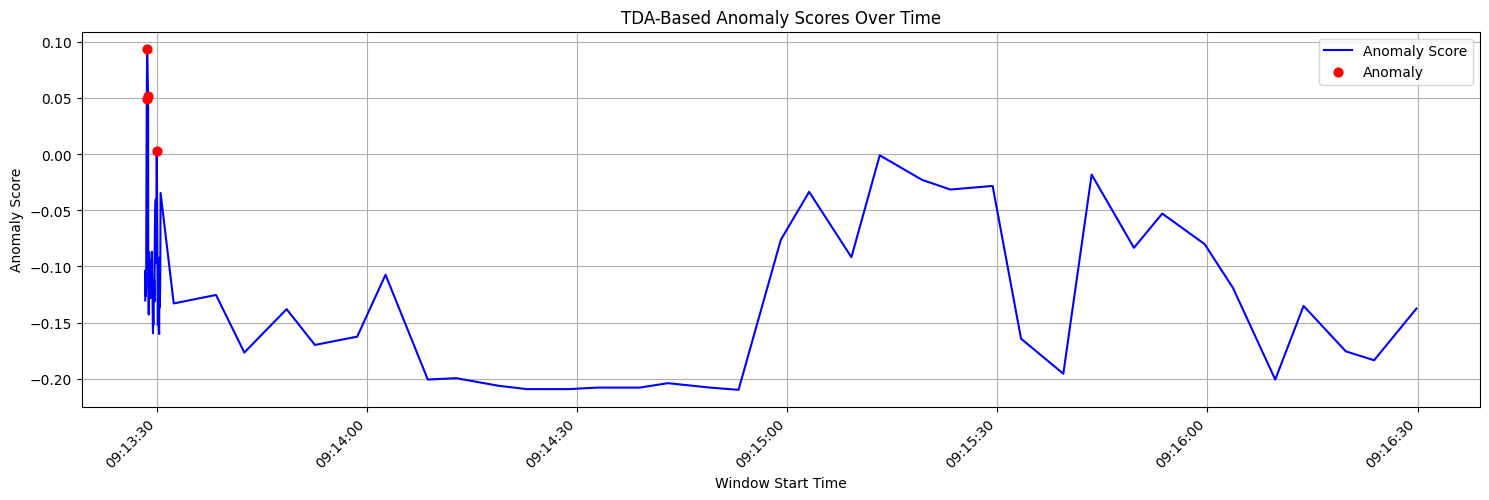

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
df_plot['score'].plot(label='Anomaly Score', color='blue')

# Red dots = model-detected anomalies
anomalies = df_plot[df_plot['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['score'], color='red', label='Model Anomaly', s=40, zorder=5)

# Green dots = ground truth "Bot" windows
true_bots = df_plot[df_plot['true_bot']]
plt.scatter(true_bots.index, true_bots['score'], color='green', label='True Bot', s=40, zorder=4)

plt.title("TDA-Based Anomaly Scores with Ground Truth")
plt.xlabel("Window Start Time")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [28]:
print(anomalies)

                               score  anomaly
timestamp                                    
2018-03-02 09:13:28.595782  0.049146        1
2018-03-02 09:13:28.651586  0.094263        1
2018-03-02 09:13:28.788218  0.052499        1
2018-03-02 09:13:30.022878  0.003319        1


Computing persistence images over 77 windows…


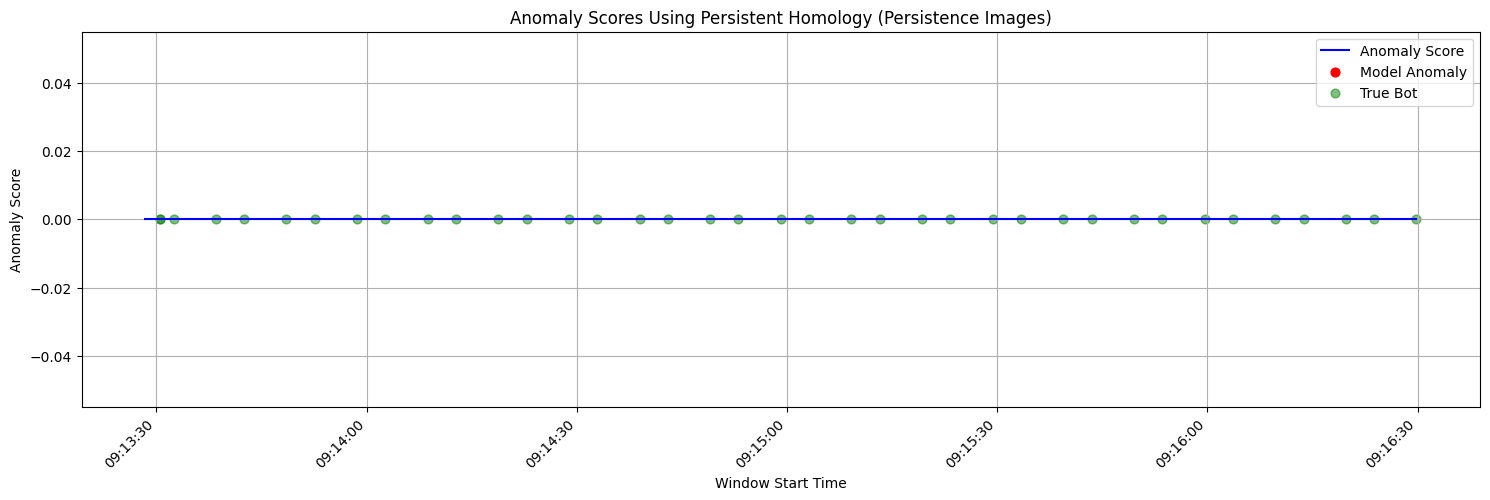

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from joblib import Parallel, delayed
import gudhi
from gudhi.representations import PersistenceImage

# --- Parameters ---
window_size = 20
stride = 5
max_dim = 1  # H0 and H1 only
resolution = [20, 20]
bandwidth = 0.1
epsilon = 1.0  # max_edge_length in Rips complex

# --- Load and process data ---
df = pd.read_csv("400-bot-combined.csv", parse_dates=["timestamp"])
df["ts_sec"] = df["timestamp"].astype("int64") / 1e9

# Feature selection and scaling
features = ["ts_sec", "duration", "packets_rate", "total_payload_bytes",
            "bytes_rate", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate"]
X = StandardScaler().fit_transform(df[features].values)

# --- Persistent Homology to Persistence Images ---
pimg = PersistenceImage(
    bandwidth=bandwidth,
    weight=lambda b, d: d - b,
    resolution=resolution,
    im_range=[0, epsilon, 0, epsilon]
)

def compute_pi(window):
    rips = gudhi.RipsComplex(points=window, max_edge_length=epsilon)
    st = rips.create_simplex_tree(max_dimension=max_dim)
    st.compute_persistence()
    diagrams = st.persistence()
    return pimg.fit_transform([st.persistence_intervals_in_dimension(1)])[0]  # H1

# --- Sliding windows ---
starts = list(range(0, len(X) - window_size + 1, stride))
print(f"Computing persistence images over {len(starts)} windows…")

pi_features = np.array(
    Parallel(n_jobs=-1)(
        delayed(compute_pi)(X[i : i + window_size]) for i in starts
    )
)

# --- Anomaly Detection ---
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(pi_features)
scores = -model.decision_function(pi_features)
labels = model.predict(pi_features)  # -1 = anomaly

# --- Window timestamps ---
window_timestamps = df["timestamp"].iloc[starts].reset_index(drop=True)
df_plot = pd.DataFrame({
    "timestamp": window_timestamps,
    "score": scores,
    "anomaly": (labels == -1).astype(int)
}).set_index("timestamp")

# --- Ground Truth for Label == "Bot" ---
true_bot_flags = []
for i in starts:
    window_labels = df.iloc[i : i + window_size]["label"]
    true_bot_flags.append((window_labels == "Bot").mean() > 0.5)
df_plot["true_bot"] = true_bot_flags

# --- Plotting ---
plt.figure(figsize=(15, 5))
df_plot['score'].plot(label='Anomaly Score', color='blue')

anomalies = df_plot[df_plot['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies['score'], color='red', label='Model Anomaly', s=40)

true_bots = df_plot[df_plot['true_bot']]
plt.scatter(true_bots.index, true_bots['score'], color='green', label='True Bot', s=40, alpha=0.5)

plt.title("Anomaly Scores Using Persistent Homology (Persistence Images)")
plt.xlabel("Window Start Time")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# --- Save output (optional) ---
anomalies.to_csv("detected_anomalies.csv")
print(f"{len(anomalies)} anomalies saved to detected_anomalies.csv.")